In [2]:
import tensorflow as tf
import cv2


import pickle
import os

import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths = os.path.join(dirname, filename)


In [3]:
import numpy as np
data=[]
labels=[]

height = 128
width = 128
channels = 3
classes = 43
n_inputs = height * width * channels

path1 = "../input/cervical-cancer-largest-dataset-sipakmed/im_Dyskeratotic/im_Dyskeratotic/CROPPED/"
path2 = "../input/cervical-cancer-largest-dataset-sipakmed/im_Koilocytotic/im_Koilocytotic/CROPPED/"
path3 = "../input/cervical-cancer-largest-dataset-sipakmed/im_Metaplastic/im_Metaplastic/CROPPED/"
path4 = "../input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/CROPPED/"
path5 = "../input/cervical-cancer-largest-dataset-sipakmed/im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED/"

path = [path1, path2, path3, path4, path5]

# print(Class)
i = 0
for p in path:
    Class=os.listdir(p)
    for a in Class:
        if(a[-1] == 'p'):
            labels.append(i)
            try:
                image=cv2.imread(p+a)
                image_from_array = Image.fromarray(image, 'RGB')
                size_image = image_from_array.resize((height, width))
                data.append(np.array(size_image))
            except AttributeError:
                print(" ")
    i+=1

# Converting data to ndarray - 
labels = np.array(labels)
data = np.array(data)

print(data.shape)
print(labels.shape)
print(labels)

# Randomize the order of the input images
s = np.arange(data.shape[0])
np.random.seed(43)
np.random.shuffle(s)
data = data[s]
labels = labels[s]

(4049, 128, 128, 3)
(4049,)
[0 0 0 ... 4 4 4]


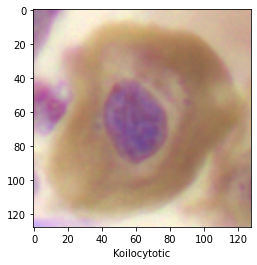

In [5]:
categories = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]

def show_the_image(i):
    plt.imshow(data[i])
    plt.xlabel(categories[labels[i]])
    
show_the_image(0)

In [6]:
from sklearn.preprocessing import LabelEncoder
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.efficientnet import EfficientNetB5
from keras.applications import imagenet_utils
import pickle

model_resnet       = ResNet50(weights = 'imagenet', include_top = False)
model_densenet     = DenseNet121(weights = 'imagenet', include_top = False)
model_efficientnet = EfficientNetB5(weights = 'imagenet', include_top = False)

features_resnet       = model_resnet.predict(data, batch_size=32)
features_densenet     = model_densenet.predict(data, batch_size=32)
features_efficientnet = model_densenet.predict(data, batch_size=32)

print(features_resnet.shape)
print(features_densenet.shape)
print(features_efficientnet.shape)

2022-11-21 02:33:12.965661: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


115277824/115263384 [==============================] - 4s 0us/step


2022-11-21 02:33:29.773401: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(4049, 4, 4, 2048)
(4049, 4, 4, 1024)
(4049, 4, 4, 1024)


In [7]:
extracted_features = []

# for feature, label in zip(features, labels):
#     feature = feature.reshape(32768)
#     feature = np.append(feature, label)
#     extracted_features.append(feature)
    
# extracted_features = np.array(extracted_features)

# print(extracted_features)


for f_r, f_d, f_e, label in zip(features_resnet, features_densenet, features_efficientnet, labels):
    f_r = f_r.reshape(32768)
    f_d = f_d.reshape(16384)
    f_e = f_e.reshape(16384)
    f_r = np.append(f_r, f_d)
    f_r = np.append(f_r, f_e)
    f_r = np.append(f_r, label)
    extracted_features.append(f_r)
    
extracted_features = np.array(extracted_features)

print(extracted_features.shape)

(4049, 65537)


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [9]:
X = extracted_features[:, 0:-1]
y = extracted_features[:, -1]

# scaler = StandardScaler()
# scaler.fit(X)
# scaled_X = scaler.transform(X)

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

In [10]:
# PCA :-

pca = PCA(n_components = 0.95)
pca.fit(scaled_X)
principal_X = pca.transform(scaled_X)

In [12]:
# Check the values of eigen vectors prodeced by principal components
print(pca.components_)

# check how much variance is explained by each principal component

print(pca.explained_variance_ratio_)

[[ 2.99657106e-04  1.57778632e-05  2.97779969e-05 ...  5.92393754e-03
   8.45420783e-03  3.22047602e-03]
 [-2.49220838e-03  1.66519760e-04 -2.36652802e-05 ...  6.01128903e-04
  -2.77167063e-03  2.79012102e-03]
 [ 2.31532366e-03  1.11386606e-03  1.04985776e-05 ... -2.38437284e-03
  -3.57637801e-03 -5.92246922e-03]
 ...
 [ 1.91835019e-03  1.22883030e-02  1.01654944e-03 ...  2.60931491e-03
   2.04863487e-03  8.63567119e-04]
 [ 4.85232273e-03 -6.97716213e-03  2.42063662e-03 ...  3.45323020e-04
   2.04775623e-03 -4.60813651e-03]
 [-5.38882182e-03  8.83805983e-03 -1.02177866e-03 ...  2.13881824e-03
  -1.60843871e-03  7.42665528e-04]]
[1.59796083e-01 9.69516255e-02 3.14461153e-02 ... 5.02687698e-05
 5.02388814e-05 5.01932003e-05]


In [13]:
# Train-Test-Split :-

X_train, X_test, y_train, y_test = train_test_split(principal_X, y, test_size = 0.2, random_state = 1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3239, 2081)
(810, 2081)
(3239,)
(810,)


In [12]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)
y_svm = svm.predict(X_test)

In [13]:
print(y_svm[0:10])
print(y_test[0:10])

[3. 1. 2. 1. 2. 1. 2. 1. 4. 3.]
[3. 1. 2. 1. 2. 2. 2. 1. 4. 3.]


In [14]:
from sklearn import metrics

acc_svm = metrics.accuracy_score(y_test, y_svm)
print("Accuracy of SVM: ", acc_svm*100)

Accuracy of SVM:  94.19753086419753


In [15]:
from sklearn.metrics import confusion_matrix, classification_report

print("Classification Report: \n", classification_report(y_test, y_svm))

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       167
         1.0       0.90      0.83      0.86       165
         2.0       0.88      0.92      0.90       132
         3.0       1.00      1.00      1.00       174
         4.0       0.97      0.97      0.97       172

    accuracy                           0.94       810
   macro avg       0.94      0.94      0.94       810
weighted avg       0.94      0.94      0.94       810



In [14]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
y_knn = model.predict(X_test)

In [19]:
from sklearn import metrics

acc_knn = metrics.accuracy_score(y_test, y_knn)
print("Accuracy of KNN: ", acc_knn*100)

Accuracy of KNN:  81.85185185185185


In [18]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=5)
model.fit(X_train, y_train)
y_rf = model.predict(X_test)

In [20]:
acc_rf = metrics.accuracy_score(y_test, y_rf)
print("Accuracy of KNN: ", acc_rf*100)

Accuracy of KNN:  49.50617283950617
